# 3.1 Develop the classification model

### Notebook goal

The aim of this notebook is to model the data to predict if a film makes a profit or not. A classification problem, the models considered in the first instance will be:

* Logistic Regression,
* Support Vector Machine,
* Decision Tree Classifier, and
* Random Forest Classifier.

In [1]:
# for the sake of development, use this magic command to solve slow suggestion
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_columns', 50)
from load_data import load_data
from preprocess_data import preprocess

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix
from sklearn.metrics import r2_score, make_scorer, f1_score

#### Load in the dataset

In [3]:
df = preprocess(load_data())
df.head()

,revenue,runtime,num_prods,num_languages,num_writers,UNRATE,PCE,class,original_language_en,original_language_fr,original_language_hi,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,genres_Adventure,genres_Animation,...,prod_comp_names_Universal_Pictures,prod_comp_names_Columbia_Pictures,prod_comp_names_Paramount,prod_comp_names_20th_Century_Fox,prod_comp_names_New_Line_Cinema,prod_comp_names_Walt_Disney_Pictures,prod_comp_names_Canal+,prod_comp_names_Metro-Goldwyn-Mayer,prod_comp_names_Touchstone_Pictures,prod_comp_names_Relativity_Media,prod_comp_names_Miramax,prod_comp_cntry_US,prod_comp_cntry_GB,prod_comp_cntry_FR,num_top_100_actors,established_director,log10_budget,log10_director_pop,log10_avg_writer_pop,log10_max_writer_pop,log10_avg_actor_pop,log10_max_actor_pop,log10_min_actor_pop,log10_cast_crew_sum_pop,log10_cast_crew_product_pop
0,2.215460e+08,81.0,1,1,5,5.5,5013.9,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,7.250232,0.525304,0.652182,0.822822,1.051268,1.429510,0.393048,1.280904,2.228754
1,1.562650e+08,104.0,4,2,3,5.6,5097.5,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,7.587154,0.471732,0.260389,0.629817,0.876776,1.069668,0.318272,1.090399,1.608897
2,4.843322e+07,127.0,1,1,2,5.6,5097.5,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.0,6.978361,0.725830,-0.175874,0.146438,0.524006,0.754578,0.199206,0.969789,1.073962
3,1.114540e+08,170.0,3,2,1,5.6,5097.5,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,1.0,7.552392,0.962985,0.485863,0.962985,1.037811,1.211307,0.914079,1.364620,2.486659
4,3.191459e+07,127.0,7,2,5,5.6,5097.5,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1.0,7.537669,0.031408,0.337858,0.350829,0.858918,1.054498,0.697142,1.020292,1.228185


## 1. Classification

Develop the classification model to determine if the films make a profit or loss.

### 1.1. Preparing the data

The first steps are to split the data into the train and test set. Do this with the methods that come with sklearn and set the training set to 80% of the total. The data will then need to be scaled. A min-max scaler was chosen for this.

In [4]:
X = df.drop(['class', 'revenue'], axis=1)
y = df['class']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, train_size=0.8
)

In [6]:
X_train.head(3)

,runtime,num_prods,num_languages,num_writers,UNRATE,PCE,original_language_en,original_language_fr,original_language_hi,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,...,prod_comp_names_Universal_Pictures,prod_comp_names_Columbia_Pictures,prod_comp_names_Paramount,prod_comp_names_20th_Century_Fox,prod_comp_names_New_Line_Cinema,prod_comp_names_Walt_Disney_Pictures,prod_comp_names_Canal+,prod_comp_names_Metro-Goldwyn-Mayer,prod_comp_names_Touchstone_Pictures,prod_comp_names_Relativity_Media,prod_comp_names_Miramax,prod_comp_cntry_US,prod_comp_cntry_GB,prod_comp_cntry_FR,num_top_100_actors,established_director,log10_budget,log10_director_pop,log10_avg_writer_pop,log10_max_writer_pop,log10_avg_actor_pop,log10_max_actor_pop,log10_min_actor_pop,log10_cast_crew_sum_pop,log10_cast_crew_product_pop
5132,146.0,6,2,3,4.6,13140.9,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1.0,7.576502,0.261976,0.103348,0.261976,0.699491,0.922725,0.432328,0.908628,1.064815
1549,112.0,4,1,1,4.9,7108.9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.0,7.517197,-0.149967,-0.485895,-0.008774,0.716727,0.922829,0.487563,0.795417,0.080865
1678,100.0,5,1,1,5.7,7237.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,7.357154,0.676236,0.199115,0.676236,1.067901,1.303131,0.386499,1.255731,1.943252


In [7]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [8]:
pd.DataFrame(X_train
             , columns=df.drop(['class', 'revenue'], axis=1).columns).head()

,runtime,num_prods,num_languages,num_writers,UNRATE,PCE,original_language_en,original_language_fr,original_language_hi,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,...,prod_comp_names_Universal_Pictures,prod_comp_names_Columbia_Pictures,prod_comp_names_Paramount,prod_comp_names_20th_Century_Fox,prod_comp_names_New_Line_Cinema,prod_comp_names_Walt_Disney_Pictures,prod_comp_names_Canal+,prod_comp_names_Metro-Goldwyn-Mayer,prod_comp_names_Touchstone_Pictures,prod_comp_names_Relativity_Media,prod_comp_names_Miramax,prod_comp_cntry_US,prod_comp_cntry_GB,prod_comp_cntry_FR,num_top_100_actors,established_director,log10_budget,log10_director_pop,log10_avg_writer_pop,log10_max_writer_pop,log10_avg_actor_pop,log10_max_actor_pop,log10_min_actor_pop,log10_cast_crew_sum_pop,log10_cast_crew_product_pop
0,0.566265,0.20,0.111111,0.086957,0.162162,0.878280,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.731758,0.292986,0.462765,0.292986,0.642359,0.615966,0.435301,0.483472,0.461823
1,0.429719,0.12,0.000000,0.000000,0.202703,0.456220,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.714872,0.043529,0.122899,0.129030,0.650276,0.616022,0.472055,0.411689,0.255973
2,0.381526,0.16,0.000000,0.000000,0.310811,0.465197,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.669304,0.543846,0.518003,0.543846,0.811582,0.820686,0.404806,0.703557,0.645600
3,0.429719,0.08,0.111111,0.000000,0.445946,0.768679,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.528367,0.000000,0.000000,0.000000,0.821240,0.834888,0.702565,0.615183,0.274225
4,0.381526,0.08,0.111111,0.043478,0.175676,0.644369,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.540905,0.468132,0.756459,0.772164,0.726990,0.686221,0.589887,0.658639,0.667405


### 1.2 Training the models

The four models that will be trained be trained are a Logistic Regression, a Support Vector Machine, a Decision Tree and a Random Forest. Default parameters are used for this first step of training, except for the SVM. The first step is put the models through a $K$-fold cross-validation for precision. Then test data is then scaled with a min-max scaler and used by the models to make predictions. Metrics are printed out for assessment.

In [33]:
log_clf = LogisticRegression()
svm_clf = SVC(kernel='rbf', class_weight='balanced', probability=True)
tree_clf = DecisionTreeClassifier()
forest_clf = RandomForestClassifier()

models = [log_clf, svm_clf, tree_clf, forest_clf]

#### $K$-fold cross-validation

In [10]:
precision = make_scorer(precision_score)

In [11]:
from sklearn.model_selection import cross_val_score
scores_list = []
for clf in [log_clf, svm_clf, tree_clf, forest_clf]:
    print(type(clf))
    scores = cross_val_score(clf, X_train, y_train,
                             scoring=precision, cv=10)
    scores_list.append(scores)
#     print(scores)
    print("precision mean: {:.4f}".format(scores.mean()))
    print("precision std dev: {:.4f}".format(scores.std()))
    print()

<class 'sklearn.linear_model._logistic.LogisticRegression'>
precision mean: 0.7460
precision std dev: 0.0101

<class 'sklearn.svm._classes.SVC'>
precision mean: 0.8226
precision std dev: 0.0188

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
precision mean: 0.7462
precision std dev: 0.0169

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
precision mean: 0.7312
precision std dev: 0.0061



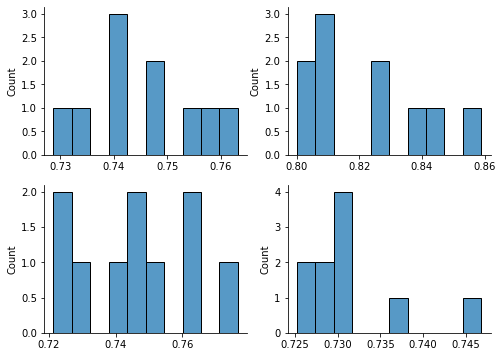

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
sns.histplot(scores_list[0], ax=ax[0][0], bins=10)
sns.histplot(scores_list[1], ax=ax[0][1], bins=10)
sns.histplot(scores_list[2], ax=ax[1][0], bins=10)
sns.histplot(scores_list[3], ax=ax[1][1], bins=10)
sns.despine(right=True)
plt.show()

#### Training on the full set - predict test and output scores

In [13]:
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

In [34]:
for clf in [log_clf, svm_clf, tree_clf, forest_clf]:
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(type(clf))
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))
    print("F1-score: {:.4f}".format(f1_score(y_test, preds)))
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, preds)))
    print("Precision: {:.4f}".format(precision_score(y_test, preds)))
    print("Recall: {:.4f}".format(recall_score(y_test, preds)))
    print()

<class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       325
           1       0.79      0.77      0.78       766

    accuracy                           0.70      1091
   macro avg       0.64      0.64      0.64      1091
weighted avg       0.70      0.70      0.70      1091

[[167 158]
 [173 593]]
F1-score: 0.7818
Accuracy: 0.6966
Precision: 0.7896
Recall: 0.7742

<class 'sklearn.svm._classes.SVC'>
              precision    recall  f1-score   support

           0       0.45      0.71      0.55       325
           1       0.84      0.63      0.72       766

    accuracy                           0.65      1091
   macro avg       0.64      0.67      0.63      1091
weighted avg       0.72      0.65      0.67      1091

[[231  94]
 [287 479]]
F1-score: 0.7155
Accuracy: 0.6508
Precision: 0.8360
Recall: 0.6253

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
              

#### We can also look at the probability predictions of the classifiers to see the distributions

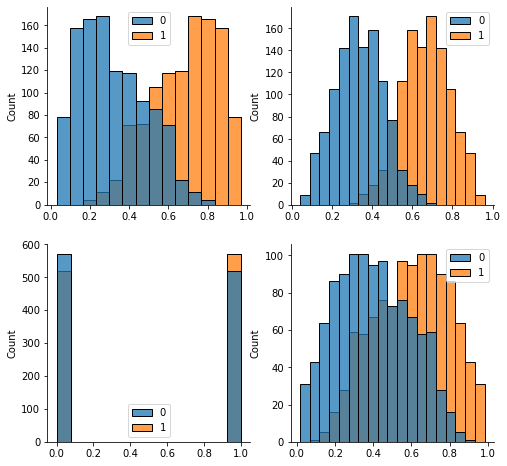

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
sns.histplot(svm_clf.predict_proba(X_test), ax=ax[0][0])
sns.histplot(forest_clf.predict_proba(X_test), ax=ax[0][1])
sns.histplot(tree_clf.predict_proba(X_test), ax=ax[1][0])
sns.histplot(log_clf.predict_proba(X_test), ax=ax[1][1])

sns.despine(right=True)
plt.show()

### 1.3 Taking models forward for tuning

The SVM and Random Forest models are taken forward. The SVM classifier had the best precision, a metric called out as one that should be given extra consideration. The Random Forest classifier had the best recall by far, which is good for this context as it means a higher percentage of profit making films were correctly predicted.

#### 1.3.1 Random Forest Tuning

In [18]:
forest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [29]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2']
    , 'max_depth' : [8,10,12,16,20]
    , 'criterion' :['gini', 'entropy']
    , 'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}
                     , {0:1, 1:5}, {0:1, 1:6}, {0:1, 1:7}, {0:1, 1:8}]
}

forest_clf = RandomForestClassifier()

# prec = make_scorer(precision_score)  

forest_grid = GridSearchCV(forest_clf, param_grid, cv=5
                           , scoring=precision, verbose=1
                           , return_train_score=True)

forest_grid.fit(X_train, y_train)

print(forest_grid.best_params_)

preds = forest_grid.predict(X_test)
print("Random Forest: Grid Search Params")
print(confusion_matrix(y_test, preds))
print("F1-score: {:.4f}".format(f1_score(y_test, preds)))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, preds)))
print("Precision: {:.4f}".format(precision_score(y_test, preds)))
print("Recall: {:.4f}".format(recall_score(y_test, preds)))

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2'}
Random Forest: Grid Search Params
[[179 146]
 [217 549]]
F1-score: 0.7515
Accuracy: 0.6673
Precision: 0.7899
Recall: 0.7167


In [43]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.58      0.13      0.22       325
           1       0.72      0.96      0.82       766

    accuracy                           0.71      1091
   macro avg       0.65      0.55      0.52      1091
weighted avg       0.68      0.71      0.64      1091



#### 1.3.2 Support Vector Machine

In [39]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [44]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    , 'gamma': ['scale', 'auto']
    , 'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}
                     , {0:1, 1:5}, {0:1, 1:6}, {0:1, 1:7}, {0:1, 1:8}]
}

svm_clf = SVC()

svm_grid = GridSearchCV(svm_clf, param_grid, cv=5
                           , scoring=precision, verbose=0
                           , return_train_score=True)

svm_grid.fit(X_train, y_train)

print(svm_grid.best_params_)

preds = svm_grid.predict(X_test)
print("SVM: Grid Search Params")
print(confusion_matrix(y_test, preds))
print("F1-score: {:.4f}".format(f1_score(y_test, preds)))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, preds)))
print("Precision: {:.4f}".format(precision_score(y_test, preds)))
print("Recall: {:.4f}".format(recall_score(y_test, preds)))

{'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
SVM: Grid Search Params
[[231  94]
 [287 479]]
F1-score: 0.7155
Accuracy: 0.6508
Precision: 0.8360
Recall: 0.6253


In [45]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.45      0.71      0.55       325
           1       0.84      0.63      0.72       766

    accuracy                           0.65      1091
   macro avg       0.64      0.67      0.63      1091
weighted avg       0.72      0.65      0.67      1091

